# Initial Set Up

## Importing libraries

In [10]:
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, Adadelta
from scikeras.wrappers import KerasClassifier

from alive_progress import alive_it
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from modules.helpers import load_data

import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow_experiment_id = 173184969061571471
mlflow.autolog(disable=True)

In [11]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) = load_data('dnn')

# Hyper Parameter Tuning

We apply early stopping to prevent overfitting.

In [12]:
early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               verbose=1,
                               patience=3)

In [13]:
def create_model(activation='relu',
                 dropout_rate=0.2, 
                 optimizer=Adam,
                 learning_rate=0.01):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(51,)), # (train_x.shape[1],)
        Dropout(dropout_rate),  
        Dense(64, activation=activation),  
        Dropout(dropout_rate),  
        Dense(32, activation=activation),  
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid') 
    ])
    opt = optimizer(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,  
        loss='binary_crossentropy',  
        metrics=['accuracy']  
    )
    
    return model

In [6]:
param_grid = {
    'activation': ['relu', 'softplus', 'sigmoid', 'tanh'],
    'dropout_rate': [0.1, 0.2, 0.3],
    'optimizer': [Adam, SGD, Adadelta],  
    'learning_rate': [0.005, 0.01]  
}

In [7]:
param_configs = [
    {
        'activation': activation,
        'dropout_rate': dropout_rate,
        'optimizer': optimizer,
        'learning_rate': learning_rate,
    }
    for activation in param_grid['activation']
    for dropout_rate in param_grid['dropout_rate']
    for optimizer in param_grid['optimizer']
    for learning_rate in param_grid['learning_rate']
]

72


In [9]:
for i in alive_it(range(len(param_configs)), force_tty=True):   
    param_config = param_configs[i]
    with mlflow.start_run(experiment_id=mlflow_experiment_id):
        for param, value in param_config.items():
            mlflow.log_param(param, value)
        
        model = create_model(**param_config)

        history = model.fit(train_x,
                train_y,
                epochs=15,
                batch_size=50,
                validation_data=(val_x, val_y))
        
        mlflow.log_metric("Accuracy", history.history['val_accuracy'])
        mlflow.log_metric("Loss", history.history['val_loss'])
        
        # Log Model
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path=f'dnn-{i}',
            registered_model_name=f'dnn-{i}'
            )
        
        del model

Epoch 1/20


/Users/sidshah/miniconda3/envs/aml/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-04-26 18:46:40.725811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-26 18:46:40.890344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


905/905 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7220 - loss: 0.5467

2024-04-26 18:46:51.196139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


905/905 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7220 - loss: 0.5467 - val_accuracy: 0.7475 - val_loss: 0.5160
Epoch 2/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7424 - loss: 0.5244 - val_accuracy: 0.7461 - val_loss: 0.5167
Epoch 3/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7464 - loss: 0.5168 - val_accuracy: 0.7484 - val_loss: 0.5144
Epoch 4/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7445 - loss: 0.5191 - val_accuracy: 0.7482 - val_loss: 0.5141
Epoch 5/20
243/905 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7485 - loss: 0.5234

KeyboardInterrupt: 

# Final Model

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(train_x.shape[1],)),
    Dropout(0.2),  
    Dense(64, activation='relu'),  
    Dropout(0.2),  
    Dense(32, activation='relu'),  
    Dropout(0.2),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy']
)

model.fit(train_x,
          train_y,
          epochs=20, 
          validation_data=(val_x, val_y))

In [ ]:
# list of possible threshold values
threshold_values = [i / 100 for i in range(10,95,5)]

# list to hold precision, recall, accuracy scores for each possible threshold value
prec_scores = []
rec_scores = []
acc_scores = []

for threshold in threshold_values:
    y_pred = (model.predict(val_x) > threshold).astype(int)
    prec_scores.append(precision_score(val_y, y_pred))
    rec_scores.append(recall_score(val_y, y_pred))
    acc_scores.append(accuracy_score(val_y, y_pred))
    
plt.plot(threshold_values, prec_scores, label='Precision')
plt.plot(threshold_values, rec_scores, label='Recall')
plt.plot(threshold_values, acc_scores, label='Accuracy')
plt.title('Choosing the Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

for i in range(len(threshold_values)):
     if acc_scores[i] > 0.7:
         print(f'- Threshold: {threshold_values[i]:.2f} | Accuracy: {acc_scores[i]:.3f} | Precision: {prec_scores[i]:.3f} | Recall: {rec_scores[i]:.3f}')

optimal_threshold = 0.45

## Model Evaluation

In [10]:
test_loss, test_acc = model.evaluate(test_x, test_y)
print("Testing loss:", test_loss)
print("Testing accuracy:", test_acc)

442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7462 - loss: 0.5094
Testing loss: 0.5113648772239685
Testing accuracy: 0.7463045716285706


In [11]:
y_pred = (model.predict(test_x) > optimal_threshold).astype(int)

442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Confusion Matrix:


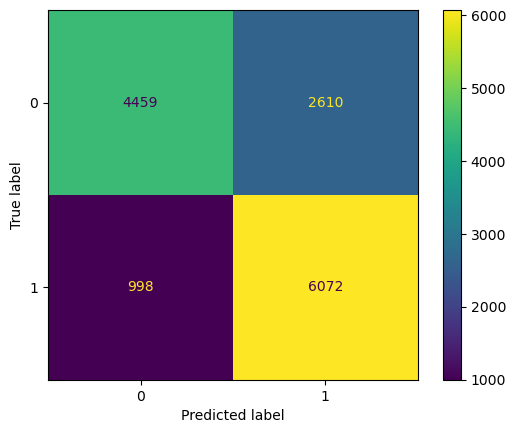

In [12]:
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [13]:
print("Classification Report:")
print(classification_report(test_y, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.63      0.71      7069
           1       0.70      0.86      0.77      7070

    accuracy                           0.74     14139
   macro avg       0.76      0.74      0.74     14139
weighted avg       0.76      0.74      0.74     14139



### Fit the data on the best model returned and evaluate performance.

In [ ]:
# build the best model
best_model = grid_result.best_estimator_

opt = grid_result.best_params_['optimizer']
if opt == 'Adam':
    optimizer = Adam(learning_rate=grid_result.best_params_['learning_rate'])
elif opt == 'SGD':
    optimier = SGD(learning_rate=grid_result.best_params_['learning_rate'])
elif opt == 'Adadelta':
    optimizer = Adadelta(learning_rate=grid_result.best_params_['learning_rate'])

best_model.compile(
        optimizer=optimizer,  
        loss='binary_crossentropy',  
        metrics=['accuracy']  
)

In [ ]:
best_model.fit(train_x,
          train_y,
          epochs=20, 
          validation_data=(val_x, val_y))

In [ ]:
test_loss, test_acc = best_model.evaluate(test_x, test_y)
print("Testing loss:", test_loss)
print("Testing accuracy:", test_acc)

In [ ]:
y_pred = (best_model.predict(test_x) > optimal_threshold).astype(int)

In [ ]:
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(test_y, y_pred))